# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                                                                                           
Sample_019  J3KQG3;Q5JZY3;Q5JZY3-2;Q5JZY3-3                                                                                             16.338
Sample_092  P06331                                                                                                                      18.914
Sample_154  D6RGW2;O95157                                                                                                               15.178
Sample_080  A0A0G2JLV7;A0A0G2JM94;A0A0G2JMI0;A0A0G2JNK8;A0A0G2JNU6;A0A0G2JP18;A0A0G2JQ50;A0A140T8W3;Q6GTX8;Q6GTX8-2;Q6GTX8-3;Q6GTX8-4   15.541
Sample_028  A0A0A6YYJ2;P42857;P42857-2                                                                                                  15.679
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                                                                          
Sample_022  P01601                                                                                     16.791
Sample_049  C9IY66;C9JNC3;H7BYC3;Q7KYR7;Q7KYR7-1;Q7KYR7-4;Q7KYR7-5;Q7KYR7-6;Q8WVV5;Q8WVV5-2;Q8WVV5-3   13.722
Sample_078  H0Y7T8;P49418;P49418-2                                                                     13.046
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.576
            A0A075B6Q5                 12.897
            A0A075B6R2                 13.015
            A0A075B6S5                 13.516
            A0A087WSY4                 13.417
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.303
            Q9UI40;Q9UI40-2            12.773
            Q9UIW2                     11.710
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.573
            Q9UP79                     12.196
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.097,15.050,16.842,19.863,15.906,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.648,19.067,...,15.528,15.576,14.331,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.924,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.324,17.705,17.039,15.631,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.298,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.567,15.345,17.084,18.708,14.249,19.433,12.108,10.884
Sample_207,15.739,16.877,15.469,16.898,13.305,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.713,11.766,11.115,13.513,13.025,12.894,12.024,12.528,14.653,12.723
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.037,19.067,16.127,...,13.069,12.219,14.253,13.523,13.252,12.458,13.385,13.374,12.990,13.450
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.976,13.031,12.682,12.933,11.861,14.017,12.818,13.224,13.031,10.661
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.525,11.105,12.354,13.312,11.640,11.493,13.235,13.868,12.094,12.408
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.071,12.413,12.593,12.126,12.699,12.679,12.182,12.244,14.092,14.426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.675,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 277.81it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

100%|██████████| 2/2 [00:00<00:00,  6.75it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.60it/s]

100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.23it/s]

100%|██████████| 4/4 [00:00<00:00,  5.62it/s]

100%|██████████| 4/4 [00:00<00:00,  6.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.04it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.29it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.28it/s]

100%|██████████| 5/5 [00:01<00:00,  3.71it/s]

100%|██████████| 5/5 [00:01<00:00,  4.22it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.12it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.57it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.22it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.96it/s]

100%|██████████| 6/6 [00:01<00:00,  2.97it/s]

100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.42it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.98it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.12it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.65it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.62it/s]

100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

100%|██████████| 7/7 [00:01<00:00,  4.99it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.15it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.69it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.44it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.66it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.07it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.89it/s]

100%|██████████| 8/8 [00:02<00:00,  2.60it/s]

100%|██████████| 8/8 [00:02<00:00,  3.19it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.57it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.44it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.90it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.84it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.88it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.75it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.73it/s]

100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

100%|██████████| 9/9 [00:03<00:00,  2.84it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.11it/s]

 40%|████      | 4/10 [00:00<00:01,  5.98it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.39it/s]

 60%|██████    | 6/10 [00:01<00:00,  5.02it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.91it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.77it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.29it/s]

100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

100%|██████████| 10/10 [00:02<00:00,  4.93it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.36it/s]

 27%|██▋       | 3/11 [00:00<00:01,  7.73it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.36it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.38it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.26it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.90it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.22it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.13it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.16it/s]

100%|██████████| 11/11 [00:01<00:00,  4.99it/s]

100%|██████████| 11/11 [00:01<00:00,  5.70it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.11it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.06it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.32it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.29it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.18it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.31it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.45it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.67it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.51it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.61it/s]

100%|██████████| 12/12 [00:02<00:00,  4.51it/s]

100%|██████████| 12/12 [00:02<00:00,  4.70it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.56it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.57it/s]

 31%|███       | 4/13 [00:00<00:01,  5.05it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.56it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.54it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.52it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.51it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.28it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.44it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.45it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.48it/s]

100%|██████████| 13/13 [00:02<00:00,  4.38it/s]

100%|██████████| 13/13 [00:02<00:00,  4.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.68it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.52it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.80it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.39it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.24it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.23it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.25it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.26it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.23it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.37it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.41it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.29it/s]

100%|██████████| 14/14 [00:03<00:00,  4.18it/s]

100%|██████████| 14/14 [00:03<00:00,  4.42it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.85it/s]

 20%|██        | 3/15 [00:00<00:02,  5.08it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.62it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.35it/s]

 40%|████      | 6/15 [00:01<00:02,  4.25it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.33it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.24it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.36it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.47it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.58it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.46it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.26it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.12it/s]

100%|██████████| 15/15 [00:03<00:00,  4.08it/s]

100%|██████████| 15/15 [00:03<00:00,  4.39it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.053 0.022          0.858 0.236       0.154   
2             0.004 0.003      0.044 0.014          0.675 0.112       0.545   
3             0.005 0.005      0.050 0.018          0.697 0.105       0.628   
4             0.005 0.004      0.045 0.016          0.721 0.098       0.660   
5             0.004 0.003      0.046 0.022          0.702 0.098       0.677   
6             0.004 0.003      0.043 0.014          0.803 0.079       0.797   
7             0.005 0.005      0.067 0.031          0.803 0.079       0.799   
8             0.006 0.005      0.058 0.026          0.801 0.082       0.794   
9             0.007 0.008      0.060 0.026          0.798 0.085       0.781   
10            0.004 0.001      0.035 0.002          0.798 0.086       0.786   
11            0.004 0.002      0.038 0.010          0.814 0.088       0.812   
12            0.004 0.003      0.033 0.008          0.814 0.088       0.820   
13            0.004 0.002      0.034 0.012          0.813 0.088       0.820   
14            0.004 0.002      0.037 0.008          0.819 0.085       0.804   
15            0.004 0.002      0.036 0.004          0.814 0.089       0.798   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.253 0.122                  0.569 0.041        0.855   
2          0.107   0.595 0.085                  0.672 0.062        0.726   
3          0.131   0.650 0.089                  0.709 0.068        0.791   
4          0.111   0.682 0.077                  0.733 0.061        0.819   
5          0.113   0.684 0.085                  0.731 0.070        0.817   
6          0.110   0.795 0.071                  0.826 0.058        0.897   
7          0.108   0.796 0.071                  0.827 0.059        0.895   
8          0.103   0.793 0.070                  0.824 0.058        0.895   
9          0.105   0.785 0.073                  0.817 0.060        0.893   
10         0.107   0.787 0.076                  0.819 0.063        0.896   
11         0.101   0.809 0.072                  0.836 0.062        0.906   
12         0.092   0.813 0.071                  0.840 0.061        0.905   
13         0.094   0.813 0.072                  0.840 0.062        0.904   
14         0.101   0.808 0.076                  0.836 0.063        0.911   
15         0.101   0.802 0.077                  0.831 0.065        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.825 0.088        210.000 0.000  
2          0.079                  0.683 0.100        210.000 0.000  
3          0.072                  0.719 0.095        210.000 0.000  
4          0.063                  0.783 0.088        210.000 0.000  
5          0.059                  0.778 0.088        210.000 0.000  
6          0.046                  0.869 0.060        210.000 0.000  
7          0.047                  0.867 0.061        210.000 0.000  
8          0.049                  0.866 0.064        210.000 0.000  
9          0.050                  0.864 0.063        210.000 0.000  
10         0.050                  0.873 0.059        210.000 0.000  
11         0.050                  0.889 0.056        210.000 0.000  
12         0.052                  0.891 0.054        210.000 0.000  
13         0.052                  0.891 0.054        210.000 0.000  
14         0.049                  0.900 0.050        210.000 0.000  
15         0.050                  0.898 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 544.71it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.67it/s]

100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.05it/s]

100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

100%|██████████| 3/3 [00:00<00:00,  5.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.26it/s]

100%|██████████| 4/4 [00:00<00:00,  3.94it/s]

100%|██████████| 4/4 [00:00<00:00,  4.10it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.29it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.76it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.66it/s]

100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.13it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.64it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.81it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.51it/s]

100%|██████████| 6/6 [00:01<00:00,  4.21it/s]

100%|██████████| 6/6 [00:01<00:00,  4.66it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.35it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.97it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.16it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.89it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.39it/s]

100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.13it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.43it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.53it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.25it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.09it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.07it/s]

100%|██████████| 8/8 [00:01<00:00,  4.11it/s]

100%|██████████| 8/8 [00:01<00:00,  4.43it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.71it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.86it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.29it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.99it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.51it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.34it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.12it/s]

100%|██████████| 9/9 [00:02<00:00,  3.69it/s]

100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.82it/s]

 30%|███       | 3/10 [00:00<00:01,  5.75it/s]

 40%|████      | 4/10 [00:00<00:01,  5.19it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.99it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.64it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.57it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.21it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.11it/s]

100%|██████████| 10/10 [00:02<00:00,  2.71it/s]

100%|██████████| 10/10 [00:02<00:00,  3.73it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.99it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.44it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.22it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.22it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.11it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.43it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.07it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.86it/s]

 91%|█████████ | 10/11 [00:02<00:00,  2.90it/s]

100%|██████████| 11/11 [00:03<00:00,  3.14it/s]

100%|██████████| 11/11 [00:03<00:00,  3.46it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.76it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.67it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.53it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.34it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.19it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.01it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.44it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.27it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.01it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.88it/s]

100%|██████████| 12/12 [00:03<00:00,  2.94it/s]

100%|██████████| 12/12 [00:03<00:00,  3.50it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.94it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.97it/s]

 31%|███       | 4/13 [00:01<00:03,  2.41it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.24it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.23it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.36it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.44it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.56it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.72it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.93it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  3.22it/s]

100%|██████████| 13/13 [00:04<00:00,  3.41it/s]

100%|██████████| 13/13 [00:04<00:00,  2.81it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.24it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.64it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.75it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.31it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.20it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.10it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.11it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.97it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.97it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.04it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.64it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.53it/s]

100%|██████████| 14/14 [00:04<00:00,  2.32it/s]

100%|██████████| 14/14 [00:04<00:00,  3.27it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.50it/s]

 20%|██        | 3/15 [00:00<00:03,  3.19it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.59it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.36it/s]

 40%|████      | 6/15 [00:02<00:03,  2.34it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.41it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.57it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.44it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.52it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.58it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.67it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.80it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  3.00it/s]

100%|██████████| 15/15 [00:05<00:00,  3.13it/s]

100%|██████████| 15/15 [00:05<00:00,  2.76it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.035 0.005          0.108 0.283       0.012   
2             0.003 0.000      0.035 0.004          0.769 0.099       0.680   
3             0.003 0.000      0.034 0.001          0.726 0.094       0.670   
4             0.003 0.000      0.044 0.018          0.759 0.088       0.736   
5             0.004 0.003      0.046 0.016          0.822 0.091       0.780   
6             0.003 0.001      0.035 0.004          0.809 0.088       0.786   
7             0.002 0.002      0.021 0.007          0.809 0.087       0.781   
8             0.003 0.000      0.032 0.002          0.807 0.090       0.778   
9             0.005 0.004      0.050 0.018          0.785 0.094       0.774   
10            0.006 0.006      0.066 0.021          0.785 0.098       0.779   
11            0.004 0.003      0.044 0.015          0.795 0.102       0.788   
12            0.006 0.006      0.050 0.019          0.819 0.085       0.824   
13            0.005 0.005      0.054 0.027          0.827 0.089       0.817   
14            0.005 0.005      0.047 0.020          0.825 0.081       0.807   
15            0.005 0.004      0.045 0.017          0.822 0.086       0.800   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.034   0.021 0.057                  0.502 0.015        0.859   
2          0.107   0.716 0.080                  0.763 0.061        0.850   
3          0.105   0.692 0.081                  0.741 0.063        0.873   
4          0.114   0.742 0.079                  0.781 0.063        0.877   
5          0.103   0.796 0.075                  0.826 0.062        0.906   
6          0.110   0.793 0.079                  0.824 0.065        0.905   
7          0.097   0.790 0.069                  0.822 0.057        0.907   
8          0.099   0.787 0.070                  0.819 0.058        0.905   
9          0.111   0.774 0.080                  0.807 0.066        0.911   
10         0.110   0.776 0.079                  0.809 0.066        0.910   
11         0.112   0.785 0.080                  0.817 0.068        0.911   
12         0.104   0.817 0.072                  0.844 0.061        0.922   
13         0.099   0.818 0.071                  0.845 0.061        0.921   
14         0.083   0.812 0.058                  0.839 0.048        0.928   
15         0.095   0.806 0.067                  0.835 0.055        0.928   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.828 0.085        210.000 0.000  
2          0.056                  0.809 0.076        210.000 0.000  
3          0.053                  0.848 0.062        210.000 0.000  
4          0.055                  0.851 0.064        210.000 0.000  
5          0.047                  0.890 0.053        210.000 0.000  
6          0.044                  0.889 0.049        210.000 0.000  
7          0.046                  0.887 0.055        210.000 0.000  
8          0.045                  0.886 0.054        210.000 0.000  
9          0.044                  0.889 0.055        210.000 0.000  
10         0.046                  0.889 0.054        210.000 0.000  
11         0.045                  0.890 0.054        210.000 0.000  
12         0.042                  0.903 0.050        210.000 0.000  
13         0.042                  0.903 0.050        210.000 0.000  
14         0.037                  0.911 0.045        210.000 0.000  
15         0.038                  0.910 0.045 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1265.63it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 31.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 25.21it/s]

100%|██████████| 3/3 [00:00<00:00, 25.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.84it/s]

100%|██████████| 4/4 [00:00<00:00, 20.32it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 22.37it/s]

100%|██████████| 5/5 [00:00<00:00, 18.05it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.43it/s]

100%|██████████| 6/6 [00:00<00:00, 19.37it/s]

100%|██████████| 6/6 [00:00<00:00, 19.73it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.51it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.23it/s]

100%|██████████| 7/7 [00:00<00:00, 17.17it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 22.05it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.70it/s]

100%|██████████| 8/8 [00:00<00:00, 15.69it/s]

100%|██████████| 8/8 [00:00<00:00, 16.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 25.23it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.05it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.24it/s]

100%|██████████| 9/9 [00:00<00:00, 16.00it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.38it/s]

 60%|██████    | 6/10 [00:00<00:00, 16.10it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.95it/s]

100%|██████████| 10/10 [00:00<00:00, 14.96it/s]

100%|██████████| 10/10 [00:00<00:00, 15.70it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.56it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.79it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.61it/s]

 91%|█████████ | 10/11 [00:00<00:00, 16.44it/s]

100%|██████████| 11/11 [00:00<00:00, 15.84it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 26.62it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.78it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 17.34it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 16.69it/s]

100%|██████████| 12/12 [00:00<00:00, 17.96it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.19it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.99it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 17.87it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 16.59it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 15.01it/s]

100%|██████████| 13/13 [00:00<00:00, 16.18it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 23.35it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.93it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.38it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.46it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.60it/s]

100%|██████████| 14/14 [00:00<00:00, 15.25it/s]

100%|██████████| 14/14 [00:00<00:00, 15.97it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 23.88it/s]

 40%|████      | 6/15 [00:00<00:00, 18.93it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 18.56it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 18.37it/s]

 80%|████████  | 12/15 [00:00<00:00, 17.06it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 16.23it/s]

100%|██████████| 15/15 [00:00<00:00, 17.19it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.049 0.019          0.000 0.000       0.000   
2             0.004 0.003      0.043 0.014          0.040 0.198       0.002   
3             0.005 0.005      0.051 0.024          0.499 0.210       0.159   
4             0.005 0.004      0.048 0.016          0.635 0.105       0.534   
5             0.005 0.005      0.051 0.021          0.648 0.094       0.556   
6             0.005 0.004      0.047 0.018          0.655 0.090       0.557   
7             0.006 0.006      0.051 0.021          0.622 0.096       0.544   
8             0.006 0.005      0.052 0.019          0.708 0.091       0.668   
9             0.005 0.004      0.053 0.022          0.706 0.079       0.649   
10            0.005 0.004      0.053 0.020          0.699 0.084       0.640   
11            0.005 0.005      0.057 0.025          0.715 0.090       0.670   
12            0.006 0.005      0.054 0.020          0.724 0.084       0.675   
13            0.005 0.005      0.051 0.027          0.718 0.080       0.669   
14            0.006 0.006      0.059 0.028          0.720 0.084       0.678   
15            0.005 0.005      0.060 0.025          0.715 0.078       0.658   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.737   
2          0.011   0.004 0.021                  0.501 0.006        0.594   
3          0.083   0.231 0.103                  0.517 0.046        0.569   
4          0.098   0.575 0.086                  0.652 0.066        0.748   
5          0.093   0.592 0.071                  0.665 0.053        0.756   
6          0.090   0.597 0.072                  0.669 0.053        0.755   
7          0.092   0.575 0.077                  0.649 0.059        0.752   
8          0.103   0.681 0.074                  0.731 0.058        0.795   
9          0.117   0.669 0.077                  0.724 0.057        0.819   
10         0.112   0.661 0.078                  0.717 0.058        0.815   
11         0.103   0.686 0.077                  0.735 0.062        0.827   
12         0.095   0.694 0.070                  0.742 0.056        0.824   
13         0.103   0.687 0.073                  0.737 0.058        0.822   
14         0.098   0.693 0.072                  0.741 0.056        0.820   
15         0.106   0.680 0.074                  0.732 0.056        0.820   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.689 0.086        210.000 0.000  
2          0.121                  0.566 0.117        210.000 0.000  
3          0.069                  0.513 0.066        210.000 0.000  
4          0.062                  0.682 0.085        210.000 0.000  
5          0.063                  0.699 0.085        210.000 0.000  
6          0.062                  0.692 0.085        210.000 0.000  
7          0.060                  0.704 0.076        210.000 0.000  
8          0.057                  0.738 0.076        210.000 0.000  
9          0.053                  0.768 0.065        210.000 0.000  
10         0.054                  0.764 0.066        210.000 0.000  
11         0.055                  0.777 0.069        210.000 0.000  
12         0.053                  0.771 0.066        210.000 0.000  
13         0.055                  0.771 0.068        210.000 0.000  
14         0.054                  0.768 0.068        210.000 0.000  
15         0.055                  0.769 0.070 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,10,14
score_time,7,10,15
test_precision,1,13,12
test_recall,12,12,14
test_f1,12,13,12
test_balanced_accuracy,12,13,12
test_roc_auc,14,14,11
test_average_precision,14,14,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.84it/s]

 21%|██▏       | 3/14 [00:01<00:03,  2.79it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.43it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.46it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.41it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.48it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.76it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  3.03it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.26it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.41it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.58it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.70it/s]

100%|██████████| 14/14 [00:04<00:00,  3.73it/s]

100%|██████████| 14/14 [00:04<00:00,  3.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 26.77it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 17.88it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 16.16it/s]

 91%|█████████ | 10/11 [00:00<00:00, 13.83it/s]

100%|██████████| 11/11 [00:00<00:00, 15.07it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.74it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.04it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.92it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.92it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.98it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.10it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.07it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.05it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.04it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.22it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.12it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.19it/s]

100%|██████████| 14/14 [00:03<00:00,  4.13it/s]

100%|██████████| 14/14 [00:03<00:00,  4.12it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


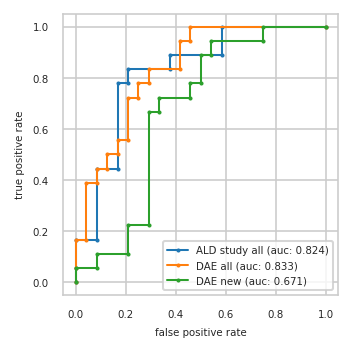

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.167   0.000 0.167   0.083 0.056
3          0.083 0.167   0.042 0.167   0.083 0.111
4          0.083 0.444   0.042 0.389   0.208 0.111
5          0.167 0.444   0.083 0.389   0.208 0.222
6          0.167 0.778   0.083 0.444   0.292 0.222
7          0.208 0.778   0.125 0.444   0.292 0.667
8          0.208 0.833   0.125 0.500   0.333 0.667
9          0.375 0.833   0.167 0.500   0.333 0.722
10         0.375 0.889   0.167 0.556   0.458 0.722
11         0.583 0.889   0.208 0.556   0.458 0.778
12         0.583 1.000   0.208 0.722   0.500 0.778
13         1.000 1.000   0.250 0.722   0.500 0.889
14           NaN   NaN   0.250 0.778   0.542 0.889
15           NaN   NaN   0.292 0.778   0.542 0.944
16           NaN   NaN   0.292 0.833   0.750 0.944
17           NaN   NaN   0.417 0.833   0.750 1.000
18           NaN   NaN   0.417 0.944   1.000 1.000
19           NaN   NaN   0.458 0.944     NaN   NaN
20           NaN   NaN   0.458 1.000     NaN   NaN
21           NaN   NaN   1.000 1.000     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q15848,Q8NFY4;Q8NFY4-6,E5RK69;E7EMC6;P08133;P08133-2
2,P01597;P04432,A0A087X1T7;E7EX88;H0YM81;P16112;P16112-2,P51688
3,P61981,P04075,P31321
4,P04075,Q9Y2T3;Q9Y2T3-3,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P14174,P61981,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
6,P00338;P00338-3,P25189;P25189-2,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
7,Q9Y2T3;Q9Y2T3-3,Q14894,Q9NUQ9
8,P25189;P25189-2,P14174,P51674;P51674-2;P51674-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


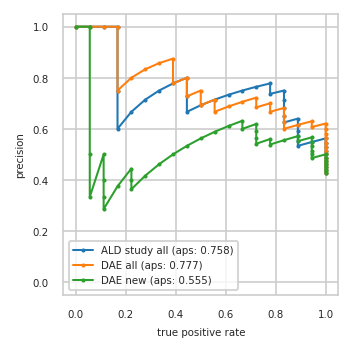

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.533 0.889     0.600 1.000     0.567 0.944
13         0.552 0.889     0.621 1.000     0.552 0.889
14         0.571 0.889     0.607 0.944     0.571 0.889
15         0.593 0.889     0.630 0.944     0.556 0.833
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.600 0.833     0.560 0.778
18         0.625 0.833     0.625 0.833     0.542 0.722
19         0.652 0.833     0.652 0.833     0.565 0.722
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.714 0.833     0.667 0.778     0.619 0.722
22         0.750 0.833     0.700 0.778     0.600 0.667
23         0.737 0.778     0.684 0.722     0.632 0.667
24         0.778 0.778     0.722 0.722     0.611 0.611
25         0.765 0.722     0.706 0.667     0.588 0.556
26         0.750 0.667     0.688 0.611     0.562 0.500
27         0.733 0.611     0.667 0.556     0.533 0.444
28         0.714 0.556     0.714 0.556     0.500 0.389
29         0.692 0.500     0.692 0.500     0.462 0.333
30         0.667 0.444     0.750 0.500     0.417 0.278
31         0.727 0.444     0.727 0.444     0.364 0.222
32         0.800 0.444     0.800 0.444     0.400 0.222
33         0.778 0.389     0.778 0.389     0.444 0.222
34         0.750 0.333     0.875 0.389     0.375 0.167
35         0.714 0.278     0.857 0.333     0.286 0.111
36         0.667 0.222     0.833 0.278     0.333 0.111
37         0.600 0.167     0.800 0.222     0.400 0.111
38         0.750 0.167     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


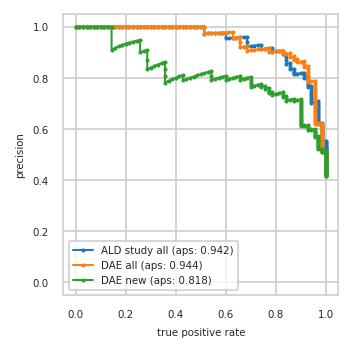

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


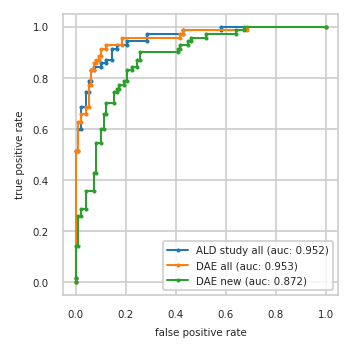

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}